<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Encoding-&amp;-Decoding-Model" data-toc-modified-id="Encoding-&amp;-Decoding-Model-1">Encoding &amp; Decoding Model</a></span><ul class="toc-item"><li><span><a href="#Upsides" data-toc-modified-id="Upsides-1.1">Upsides</a></span></li><li><span><a href="#Downsides" data-toc-modified-id="Downsides-1.2">Downsides</a></span></li><li><span><a href="#Example-applications" data-toc-modified-id="Example-applications-1.3">Example applications</a></span></li><li><span><a href="#Relevance-to-other-analysis-techniques" data-toc-modified-id="Relevance-to-other-analysis-techniques-1.4">Relevance to other analysis techniques</a></span></li></ul></li><li><span><a href="#Relevant-resources/publications" data-toc-modified-id="Relevant-resources/publications-2">Relevant resources/publications</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-3">Simulation</a></span></li></ul></div>

# Encoding & Decoding Model
Description

## Upsides

lorem

## Downsides
lorem

## Example applications
lorem

## Relevance to other analysis techniques
lorem

# Relevant resources/publications

* lorem
* lorem

# Simulation
First import the data and a few standard Python packages.

In [3]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# allows us to create tuning functions
def make_gaussian_iter(mu,sd):
    return np.array([np.roll(signal.gaussian(180, std=s),m-90) for m,s in zip(mu,sd)]).T

# allows us to calculate circular error
def circ_diff(a,b,r=180):
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -r//2:
            diff[k] = b[k] - a[k] + r
        elif diff[k] > r//2:
            diff[k] = b[k] - a[k] - r
    return diff

# pull data from GitHub
import requests, io
for array in ['trn','tst','trnf','tstf']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://github.com/PaulScotti/fmriplayground/raw/main/methods/encoding_decoding/{}.npy?raw=true'.format(array)).content),allow_pickle=True)
    
# overview of the data
num_subjects = 1
num_voxels = trn.shape[1] #20
num_trials = trn.shape[0] + tst.shape[0] #4 training trials + 4 test trials

In this simulated dataset we have 1 subject. This subject looked at an oriented grating (aka "gabor") on each of 8 trials. On every trial the gabor was a different orientation. We want to train a model that can predict the orientation of the gabor from the subject's brain activations. 

Note that we only have 8 trials in this dataset, where each trial was the presentation of a uniquely oriented gabor. A method such as multivoxel pattern classification (MVPC) would not be ideal, because MVPC can only predict stimuli that were used in the training of the model. We would need to have 180 trials, showing every possible orientation (from 0° to 179°), to be able to predict any possible orientation using MVPC. Further, MVPC treats every class (here each class is a different orientation) distinctly, without any knowledge that a gabor with orientation 30° should be treated most similarly to a gabor with orientation 31°.  

Here we want to train a flexible model that is capable of predicting any possible orientation with minimal trials and which uses the knowledge that more similar orientations should output more similar brain activity. Encoding & decoding models are perfect for such a problem. We will implement an inverted encoding model (a very simple kind of encoding and decoding model) to predict the orientation of the presented gabors.

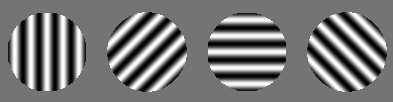 Examples of gabors with different orientations.

Let's first visualize our data. We have 8 trials, so let's train our model using the first 4 trials and test our model using the last 4 trials. We have one subject with one brain region of interest that includes 20 voxels.


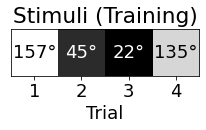

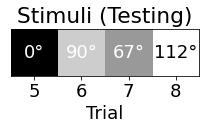

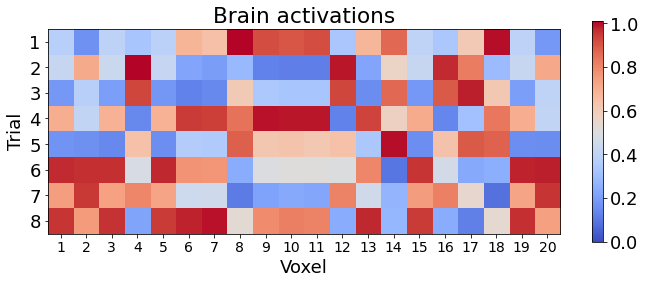

In [4]:
# change figure size
plt.rcParams.update({'font.size': 18, 'figure.figsize': (7,2)})

plt.imshow(np.array([trnf]),cmap='gray')
for i,t in enumerate(trnf):
    if t>90:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="k")
    else:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="w")
plt.yticks([])
plt.xticks(np.arange(num_trials//2),np.arange(num_trials//2)+1)
plt.xlabel("Trial")
plt.title("Stimuli (Training)")
plt.tight_layout();
plt.show()

plt.imshow(np.array([tstf]),cmap='gray')
for i,t in enumerate(tstf):
    if t>90:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="k")
    else:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="w")
plt.yticks([])
plt.xticks(np.arange(num_trials//2),np.arange(num_trials//2)+5)
plt.xlabel("Trial")
plt.title("Stimuli (Testing)")
plt.tight_layout();
plt.show()

# change figure size
plt.rcParams.update({'font.size': 18, 'figure.figsize': (10,4)})

plt.imshow(np.concatenate([trn,tst]),cmap="coolwarm",clim=[0,np.max(np.concatenate([trn,tst]))])
plt.xticks(np.arange(num_voxels),np.arange(num_voxels)+1,fontsize=14)
plt.yticks(np.arange(num_trials),np.arange(num_trials)+1)
plt.ylabel("Trial")
plt.xlabel("Voxel")
plt.title("Brain activations")
plt.colorbar()
plt.tight_layout();
plt.show()

Encoding and decoding models can be split into two steps: 

(1) building/training the encoder (a model of how the brain transforms stimuli into brain activity)

(2) predicting stimuli using the decoder (a model that predicts stimuli given brain activity).

First, let's build the encoding model. To do this, we first assume that our brain region can be represented as a series of tuning functions spanning our stimulus space (in this case, orientation). We use tuning functions as inspired from single-unit physiology, where we know that certain neurons are preferentially responsive to certain inputs.

This series of tuning functions can be referred to as the "basis set", with each tuning function being one "basis channel".

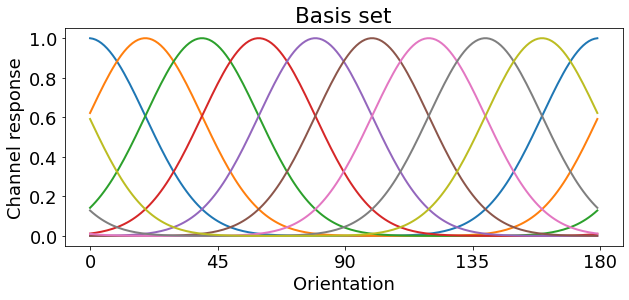

In [5]:
num_channels = 9
basis_points = np.linspace(0,180-(180//num_channels),num_channels).astype(int)
basis_set = make_gaussian_iter(basis_points, np.ones(num_channels)*20)
plt.plot(basis_set,lw=2)
plt.ylabel("Channel response")
plt.xlabel("Orientation")
plt.xticks([0,45,90,135,180])
plt.title("Basis set")
plt.show()

The choice to use nine channels with this predetermined shape is largely arbitrary and can be adapted by the experimenter depending on their specific goals.

Next, we will use this basis set. We can transform the presented stimuli (from our training data) into a matrix of channel responses.

Simply plot the location in feature space for each training trial and see where it intersects with each of the basis channels. This yields 9 channel responses for every training trial because we chose a basis set of 9 channels.

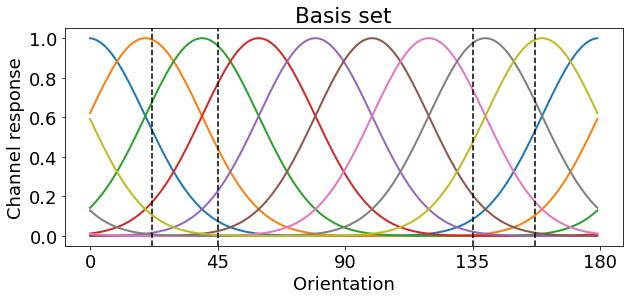

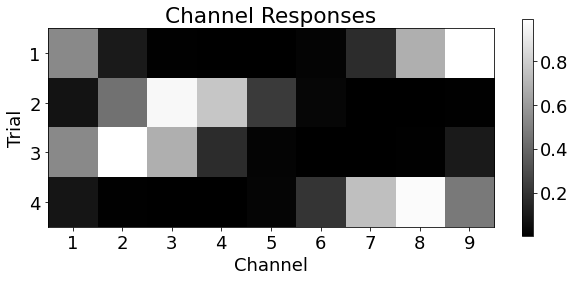

In [6]:
plt.plot(basis_set,lw=2)
plt.ylabel("Channel response")
plt.xlabel("Orientation")
plt.xticks([0,45,90,135,180])
plt.title("Basis set")
for t in trnf:
    plt.axvline(t,ls='--',c='k')
plt.show()

plt.imshow(basis_set[trnf,:],cmap='gray')
plt.yticks(np.arange(len(trnf)),np.arange(len(trnf))+1)
plt.xticks(np.arange(num_channels),np.arange(num_channels)+1)
plt.xlabel("Channel")
plt.ylabel("Trial")
plt.title("Channel Responses")
plt.colorbar()
plt.show()

The complete encoding model is as follows:

Channel Responses x Estimated Weights = Brain Activations

So, we need to figure out the only unknown quantity in this equation, which is the weights. We can estimate these weights using ordinary least-squares estimation (i.e., linear regression).

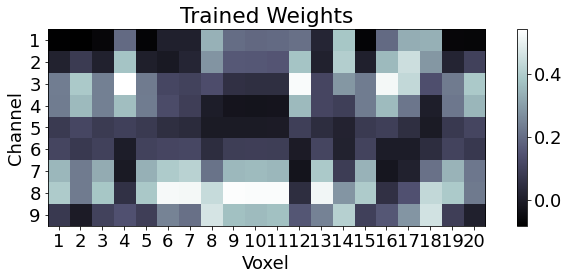

In [7]:
cr = np.linalg.lstsq(basis_set[trnf,:], trn, rcond=None)[0]
plt.imshow(cr,cmap='bone')
plt.xticks(np.arange(trn.shape[1]),np.arange(trn.shape[1])+1)
plt.yticks(np.arange(num_channels),np.arange(num_channels)+1)
plt.xlabel("Voxel")
plt.ylabel("Channel")
plt.title("Trained Weights")
plt.colorbar()
plt.tight_layout();
plt.show()

Now we can move on to the decoding model, which will use our trained weights to decode stimuli. The decoding model is as follows:

Estimated Channel Responses x Trained Weights = Brain Activations

Again, we can use linear regression to estimate the channel responses.

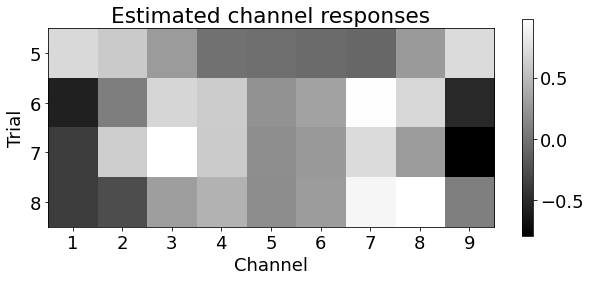

In [8]:
cw = np.linalg.lstsq(cr.T, tst.T, rcond=None)[0].T

plt.imshow(cw,cmap='gray')
plt.yticks(np.arange(len(trnf)),np.arange(len(trnf))+5)
plt.xticks(np.arange(num_channels),np.arange(num_channels)+1)
plt.xlabel("Channel")
plt.ylabel("Trial")
plt.title("Estimated channel responses")
plt.colorbar()
plt.show()

Now let's plot our estimated channel responses obtained from the decoder! The estimated channel responses can also be referred to as "reconstructions".

To obtain a concrete stimulus prediction for each reconstruction we will simply take the highest channel response of the reconstruction. We can then compare our predictions to the actual stimuli to see how well our decoding model performed.

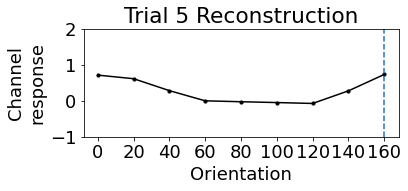

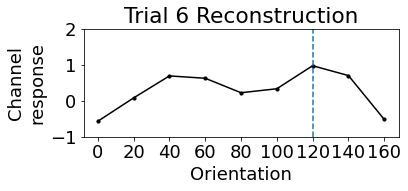

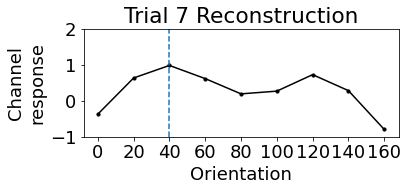

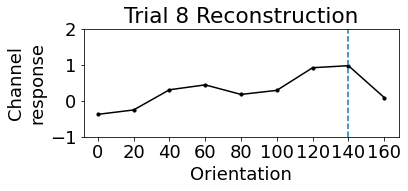

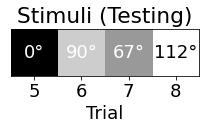

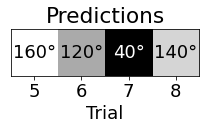

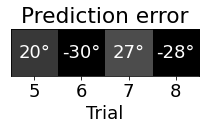

In [9]:
# change figure size
plt.rcParams.update({'font.size': 18, 'figure.figsize': (6,3)})

predictions=[]
for i in range(len(trnf)):
    plt.plot(cw[i,:],c='k')
    plt.scatter(np.arange(num_channels),cw[i,:],c='k',s=10)
    plt.xticks(np.arange(num_channels),basis_points)
    plt.ylabel("Channel\nresponse")
    plt.xlabel("Orientation")
    plt.yticks([-1,0,1,2])
    plt.ylim([-1,2])
    plt.title("Trial {} Reconstruction".format(i+5))
    plt.axvline(np.argmax(cw[i,:]),ls='--')
    predictions = np.append(predictions,basis_points[np.argmax(cw[i,:])])
    plt.tight_layout();
    plt.show()

# change figure size
plt.rcParams.update({'font.size': 18, 'figure.figsize': (7,2)})

predictions = predictions.astype(int)
plt.imshow(np.array([tstf]),cmap='gray')
for i,t in enumerate(tstf):
    if t>90:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="k")
    else:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="w")
plt.yticks([])
plt.xticks(np.arange(num_trials//2),np.arange(num_trials//2)+5)
plt.xlabel("Trial")
plt.title("Stimuli (Testing)")
plt.tight_layout();
plt.show()

plt.imshow(np.array([predictions]),cmap='gray')
for i,t in enumerate(predictions):
    if t>90:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="k")
    else:
        plt.text(i, 0, str(t)+"°", ha="center", va="center", color="w")
plt.yticks([])
plt.xticks(np.arange(num_trials//2),np.arange(num_trials//2)+5)
plt.xlabel("Trial")
plt.title("Predictions")
plt.tight_layout();
plt.show()

errors = circ_diff(predictions,tstf).astype(int)
plt.imshow([errors],cmap='gray',clim=[0,90])
for i,t in enumerate(errors):
    plt.text(i, 0, str(t)+"°", ha="center", va="center", color="w")
plt.yticks([])
plt.xticks(np.arange(num_trials//2),np.arange(num_trials//2)+5)
plt.xlabel("Trial")
plt.title("Prediction error")
plt.tight_layout();
plt.show()


In [4]:
## Code used to simulate the data instead of loading it from GitHub: ##
import numpy as np
from scipy import signal

# allows us to create tuning functions
def make_gaussian_iter(mu,sd):
    return np.array([np.roll(signal.gaussian(180, std=s),m-90) for m,s in zip(mu,sd)]).T

nchannels = 9
np.random.seed(1)
num_trials = 8
nvoxels = 20
rand_noise = 0.01
sd = 42
trial_features = np.random.permutation(np.linspace(0,(180-(180/num_trials)),num_trials)).astype(int)

vox_noise = np.random.normal(0,rand_noise,(num_trials,nvoxels))
vox_mu_basis = np.linspace(0,180-(180//nchannels),nchannels).astype(int)
channel_sd = np.ones(nchannels)*sd

# Simulate voxels 
trial_by_vox = np.full((num_trials,nvoxels),np.nan)
for vox in np.arange(nvoxels):
    vox_tuning = make_gaussian_iter([vox_mu_basis[np.random.choice(nchannels)]],[sd])
    for trial in range(num_trials):
        trial_by_vox[trial,vox] = vox_tuning[trial_features[trial]]+vox_noise[trial,vox]

basis_set = make_gaussian_iter(vox_mu_basis, channel_sd)

trn = trial_by_vox[:num_trials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:num_trials//2]) # training trial features
tst = trial_by_vox[num_trials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[num_trials//2:]) # test trial features

np.save('trn.npy',trn)
np.save('trnf.npy',trnf)
np.save('tst.npy',tst)
np.save('tstf.npy',tstf)